In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

import random
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.model_selection import KFold

from thor_magni_actions.data_modeling.cfgs.seeds import K_FOLD_SEED
from thor_magni_actions.data_modeling.models import LightDiscriminativePredictor, LightMultiTaskPredictor

from thor_magni_actions.data_modeling.utils import load_config
from thor_magni_actions.data_modeling.datasets import DatasetObjects, get_scalers_stats
from thor_magni_actions.data_modeling.datasets import DatasetFromPath

from thor_magni_actions.data_modeling.datasets.torch_loaders import PixWorldConverter

In [9]:
DATASET = "thor_magni"

DEFAULT_CFG_PATH = "thor-magni-actions/thor_magni_actions/data_modeling/cfgs/default.yaml"
TF_BASELINE_CFG_PATH = f"thor-magni-actions/thor_magni_actions/data_modeling/cfgs/{DATASET}/tf_base_trajectory_prediction.yaml"

TF_COND_CFG_PATH = f"thor-magni-actions/thor_magni_actions/data_modeling/cfgs/{DATASET}/cond_tf.yaml"
TF_MTL_CFG_PATH = f"thor-magni-actions/thor_magni_actions/data_modeling/cfgs/{DATASET}/mtl_tf.yaml"

VISUALS_PATH = None
if DATASET == "thor_magni":
    VISUALS_PATH =  "datasets/thor_magni_pub_ready/maps/"

In [10]:
tf_base_cfg = load_config(TF_BASELINE_CFG_PATH, DEFAULT_CFG_PATH)

data_cfg = tf_base_cfg["data"]
observation_len = data_cfg["observation_len"]
prediction_len = data_cfg["prediction_len"]
trajectory_len = data_cfg["observation_len"] + data_cfg["prediction_len"]
tf_base_net_cfg = tf_base_cfg["network"]

test_dataset = data_cfg["test_dataset"]
path_ds_target = path_ds_target = os.path.join(
    "thor-magni-actions", data_cfg["data_dir"]
)
tf_hyperparameters_cfg = tf_base_cfg["hyperparameters"]
dataset_name = data_cfg["dataset"]

In [11]:
tf_cond_cfg = load_config(TF_COND_CFG_PATH, DEFAULT_CFG_PATH)
tf_mtl_cfg = load_config(TF_MTL_CFG_PATH, DEFAULT_CFG_PATH)

In [12]:
all_trajectories = DatasetFromPath.get_data(
    path_ds_target, "train" if dataset_name == "synthetic" else test_dataset
)
trajectories_tracklets = all_trajectories.groupby(
    "ag_id" if dataset_name == "synthetic" else ["dataset_name", "tracklet_id"]
)
input_trajectories = [tracklet for _, tracklet in trajectories_tracklets]
random.seed(K_FOLD_SEED)
random.shuffle(input_trajectories)

In [13]:
dummy_x = np.random.randn(len(input_trajectories), 1)
kf = KFold(n_splits=5)

In [14]:
folds = {}
for i, (train_index, validation_index) in enumerate(kf.split(dummy_x)):
    train_trajectories = pd.concat(
        [input_trajectories[train_i] for train_i in train_index]
    )
    validation_trajectories = pd.concat(
        [input_trajectories[val_i] for val_i in validation_index]
    )
    train_objects = DatasetObjects(
        set_type="train",
        data_cfg=data_cfg,
        dataset_dataframe=train_trajectories,
    )
    train_ds = train_objects.load_dataset()
    val_objects = DatasetObjects(
        set_type="val",
        data_cfg=data_cfg,
        dataset_dataframe=validation_trajectories,
    )
    val_objects.features_scaler = deepcopy(train_objects.features_scaler)
    val_ds = val_objects.load_dataset()
    features_scalers_stats = get_scalers_stats(
        train_features_scaler=train_objects.features_scaler,
        val_features_scaler=val_objects.features_scaler,
    )
    folds[i] = (
        DataLoader(val_ds, batch_size=tf_hyperparameters_cfg["bs"], shuffle=False),
        features_scalers_stats,
    )

# Maps

In [15]:
import json

if VISUALS_PATH:
    with open(os.path.join(VISUALS_PATH, "offsets.json"), "rb") as f:
        offsets = json.load(f)
    pix2word_converters = dict(
        May=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["May"])),
        September=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["September"])),
)

# Models

In [16]:
BATCH_IDX = 0 
SAMPLE_IDX = 13

In [17]:
tf_baseline_check = "/home/tmr/Documents/PhD/My_PhD/code/thor-magni-actions/logs/final_prediction/thor_magni/Scenario_3/tf/fold_2/version_0/checkpoints/epoch=47-val_loss=0.54.ckpt"
tf_cond_check = "/home/tmr/Documents/PhD/My_PhD/code/thor-magni-actions/logs/final_prediction/thor_magni/Scenario_3/cond_tf,agent_True,act_True/fold_2/version_0/checkpoints/epoch=73-val_loss=0.45.ckpt"
tf_mtl_check =  "/home/tmr/Documents/PhD/My_PhD/code/thor-magni-actions/logs/final_prediction/thor_magni/Scenario_3/mtl_tf,agent_True/fold_2/version_0/checkpoints/epoch=95-val_loss=0.71.ckpt"

In [18]:
test_dl = folds[3][0]
features_scalers_stats = folds[3][1]

In [19]:
tf_baseline_model = LightDiscriminativePredictor.load_from_checkpoint(
    tf_baseline_check,
    network_cfg=tf_base_net_cfg,
    hyperparameters_cfg=tf_hyperparameters_cfg,
    map_location={"cuda:0": "cpu"},
)

In [20]:
cond_tf_model = LightDiscriminativePredictor.load_from_checkpoint(
    tf_cond_check,
    network_cfg=tf_cond_cfg["network"],
    hyperparameters_cfg=tf_cond_cfg["hyperparameters"],
    map_location={"cuda:0": "cpu"},
)

In [21]:
data_cfg.update(dict(supervised_labels=train_ds.mapping_agent_types))
data_cfg.update(dict(actions=train_ds.mapping_actions))
mtl_tf_model = LightMultiTaskPredictor.load_from_checkpoint(
    tf_mtl_check, 
    network_cfg=tf_mtl_cfg["network"],
    hyperparameters_cfg=tf_mtl_cfg["hyperparameters"],
    data_cfg=data_cfg,
    map_location={"cuda:0": "cpu"},
)

In [22]:
tf_baseline_model.eval()
cond_tf_model.eval()
mtl_tf_model.eval()

base_out_samples = {
    "dataset" : [],
    "agent_class": [],
    "obs_gt": [],
    "pred_gt": [],
    "base_pred": [],
    "cond_tf_pred": [],
    "mtl_tf": [],
    "mtl_actions_pred" : [],
    "actions_gt" : [],
}

for batch_idx, batch in enumerate(test_dl):
    tf_base_pred = tf_baseline_model.predict_step(batch, batch_idx)
    tf_cond_pred = cond_tf_model.predict_step(batch, batch_idx)
    mtl_tf_pred = mtl_tf_model.predict_step(batch, batch_idx)
    
    base_out_samples["dataset"].append(batch["dataset"])
    base_out_samples["agent_class"].append(batch["agent_type"])
    base_out_samples["obs_gt"].append(batch["gt_obs"])
    base_out_samples["pred_gt"].append(batch["gt_pred"])
    
    # predictions
    base_out_samples["base_pred"].append(tf_base_pred["y_hat"])
    base_out_samples["cond_tf_pred"].append(tf_cond_pred["y_hat"])
    base_out_samples["mtl_tf"].append(mtl_tf_pred["traj_pred_unscaled"])
    base_out_samples["mtl_actions_pred"].append(mtl_tf_pred["act_pred"])
    base_out_samples["actions_gt"].append(mtl_tf_pred["act_pred_gt"])

In [23]:
dataset_batch = base_out_samples["dataset"][BATCH_IDX]
agent_class_batch = base_out_samples["agent_class"][BATCH_IDX][:, 0]

obs_batch = base_out_samples["obs_gt"][BATCH_IDX]
gt_batch = base_out_samples["pred_gt"][BATCH_IDX]

base_pred = base_out_samples["base_pred"][BATCH_IDX]
cond_pred = base_out_samples["cond_tf_pred"][BATCH_IDX]
mtl_pred = base_out_samples["mtl_tf"][BATCH_IDX]
mtl_actions_pred = base_out_samples["mtl_actions_pred"][BATCH_IDX]
gt_actions = base_out_samples["actions_gt"][BATCH_IDX]


In [24]:
def plot_predictions(
    tf_observations_plt,
    tf_ground_truth_plt,
    tf_base_predictions_plt,
    tf_cond_predictions_plt,
):
    plt.plot(
        tf_observations_plt[:, 0],
        tf_observations_plt[:, 1],
        color="blue",
        marker="o",
        label="Observation",
        linewidth=3,
        markersize=16,
    )
    plt.plot(
        tf_ground_truth_plt[:, 0],
        tf_ground_truth_plt[:, 1],
        color="green",
        marker="o",
        label="Ground truth",
        linewidth=3,
        markersize=16,
    )
    plt.plot(
        tf_base_predictions_plt[:, 0],
        tf_base_predictions_plt[:, 1],
        color="red",
        marker="D",
        label="Baseline",
        linewidth=5,
        markersize=16,
    )
    plt.plot(
        tf_cond_predictions_plt[:, 0],
        tf_cond_predictions_plt[:, 1],
        color="magenta",
        # marker="s",
        label="ACT-OURS",
        linewidth=5,
        markersize=16,
    )
    plt.axis("off")
    plt.tight_layout()

In [25]:
agent_class_batch[SAMPLE_IDX]

tensor(2.)

In [26]:
mtl_actions_pred[SAMPLE_IDX].argmax(dim=1)

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2])

In [27]:
gt_agent_class_name =  next(
        (
            key
            for key, value in test_dl.dataset.mapping_agent_types.items()
            if value == agent_class_batch[SAMPLE_IDX]
        ),
        None,
    )
gt_agent_class_name

'Carrier-Large Object'

In [28]:
gt_actions_class_name = []
for act in gt_actions[SAMPLE_IDX]:
    for key, value in test_dl.dataset.mapping_actions.items():
        if value == act:
            gt_actions_class_name.append(key)
gt_actions_class_name

['WalkLO',
 'WalkLO',
 'WalkLO',
 'WalkLO',
 'WalkLO',
 'DrawCard',
 'DrawCard',
 'DrawCard',
 'DrawCard',
 'DrawCard',
 'DrawCard',
 'DrawCard']

In [29]:
pred_actions_class_name = []
for act in mtl_actions_pred[SAMPLE_IDX].argmax(dim=1):
    for key, value in test_dl.dataset.mapping_actions.items():
        if value == act:
            pred_actions_class_name.append(key)
pred_actions_class_name

['WalkLO',
 'WalkLO',
 'WalkLO',
 'WalkLO',
 'WalkLO',
 'WalkLO',
 'WalkLO',
 'WalkLO',
 'WalkLO',
 'DrawCard',
 'DrawCard',
 'DrawCard']

In [30]:
action_class_pred_dict = dict(
    zip(
        test_dl.dataset.mapping_actions.keys(),
        np.round((mtl_actions_pred[SAMPLE_IDX].detach().numpy()).T*100,2),
    )
)

In [31]:
actions_probabilities = pd.DataFrame.from_dict(action_class_pred_dict)

In [32]:
actions_probabilities

,DeliverBox,DeliverBucket,DrawCard,ObserveCardDraw,PickBox,PickBucket,Walk,WalkBox,WalkBucket,WalkLO
0,0.0,0.03,3.300000,0.01,0.01,0.02,0.38,0.0,0.10,96.150002
1,0.0,0.04,3.850000,0.04,0.00,0.05,0.44,0.0,0.11,95.480003
2,0.0,0.28,7.560000,0.04,0.01,0.08,0.22,0.0,0.09,91.709999
3,0.0,0.13,8.340000,0.32,0.01,0.05,0.79,0.0,0.15,90.220001
4,0.0,0.12,13.510000,0.51,0.02,0.10,0.90,0.0,0.23,84.610001
5,0.0,0.16,24.389999,0.74,0.01,0.09,0.78,0.0,0.10,73.730003
6,0.0,0.08,23.459999,4.06,0.00,0.07,1.93,0.0,0.15,70.260002
7,0.0,0.27,26.170000,4.18,0.00,0.01,2.35,0.0,0.21,66.800003
8,0.0,0.18,41.200001,7.67,0.00,0.02,2.98,0.0,0.13,47.810001
9,0.0,0.42,47.500000,11.50,0.00,0.01,2.76,0.0,0.12,37.689999


In [33]:
ground_truth_plt = gt_batch[SAMPLE_IDX]

In [34]:
base_pred_plt = base_pred[0][SAMPLE_IDX]
cond_pred_plt = cond_pred[0][SAMPLE_IDX]

In [38]:
base_error_displacement = (ground_truth_plt - base_pred_plt).norm(p=2, dim=-1)
mtl_error_displacement = (ground_truth_plt - cond_pred_plt).norm(p=2, dim=-1)
base_ade = base_error_displacement.mean()
base_fde = base_error_displacement[-1]
mtl_ade = mtl_error_displacement.mean()
mtl_fde = mtl_error_displacement[-1]
print(
    f"Base ADE/FDE: {base_ade:1.2f}/{base_fde:1.2f}\nACT ADE/FDE:{mtl_ade:1.2f}/{mtl_fde:1.2f}"
)

Base ADE/FDE: 0.54/0.91
ACT ADE/FDE:0.16/0.08


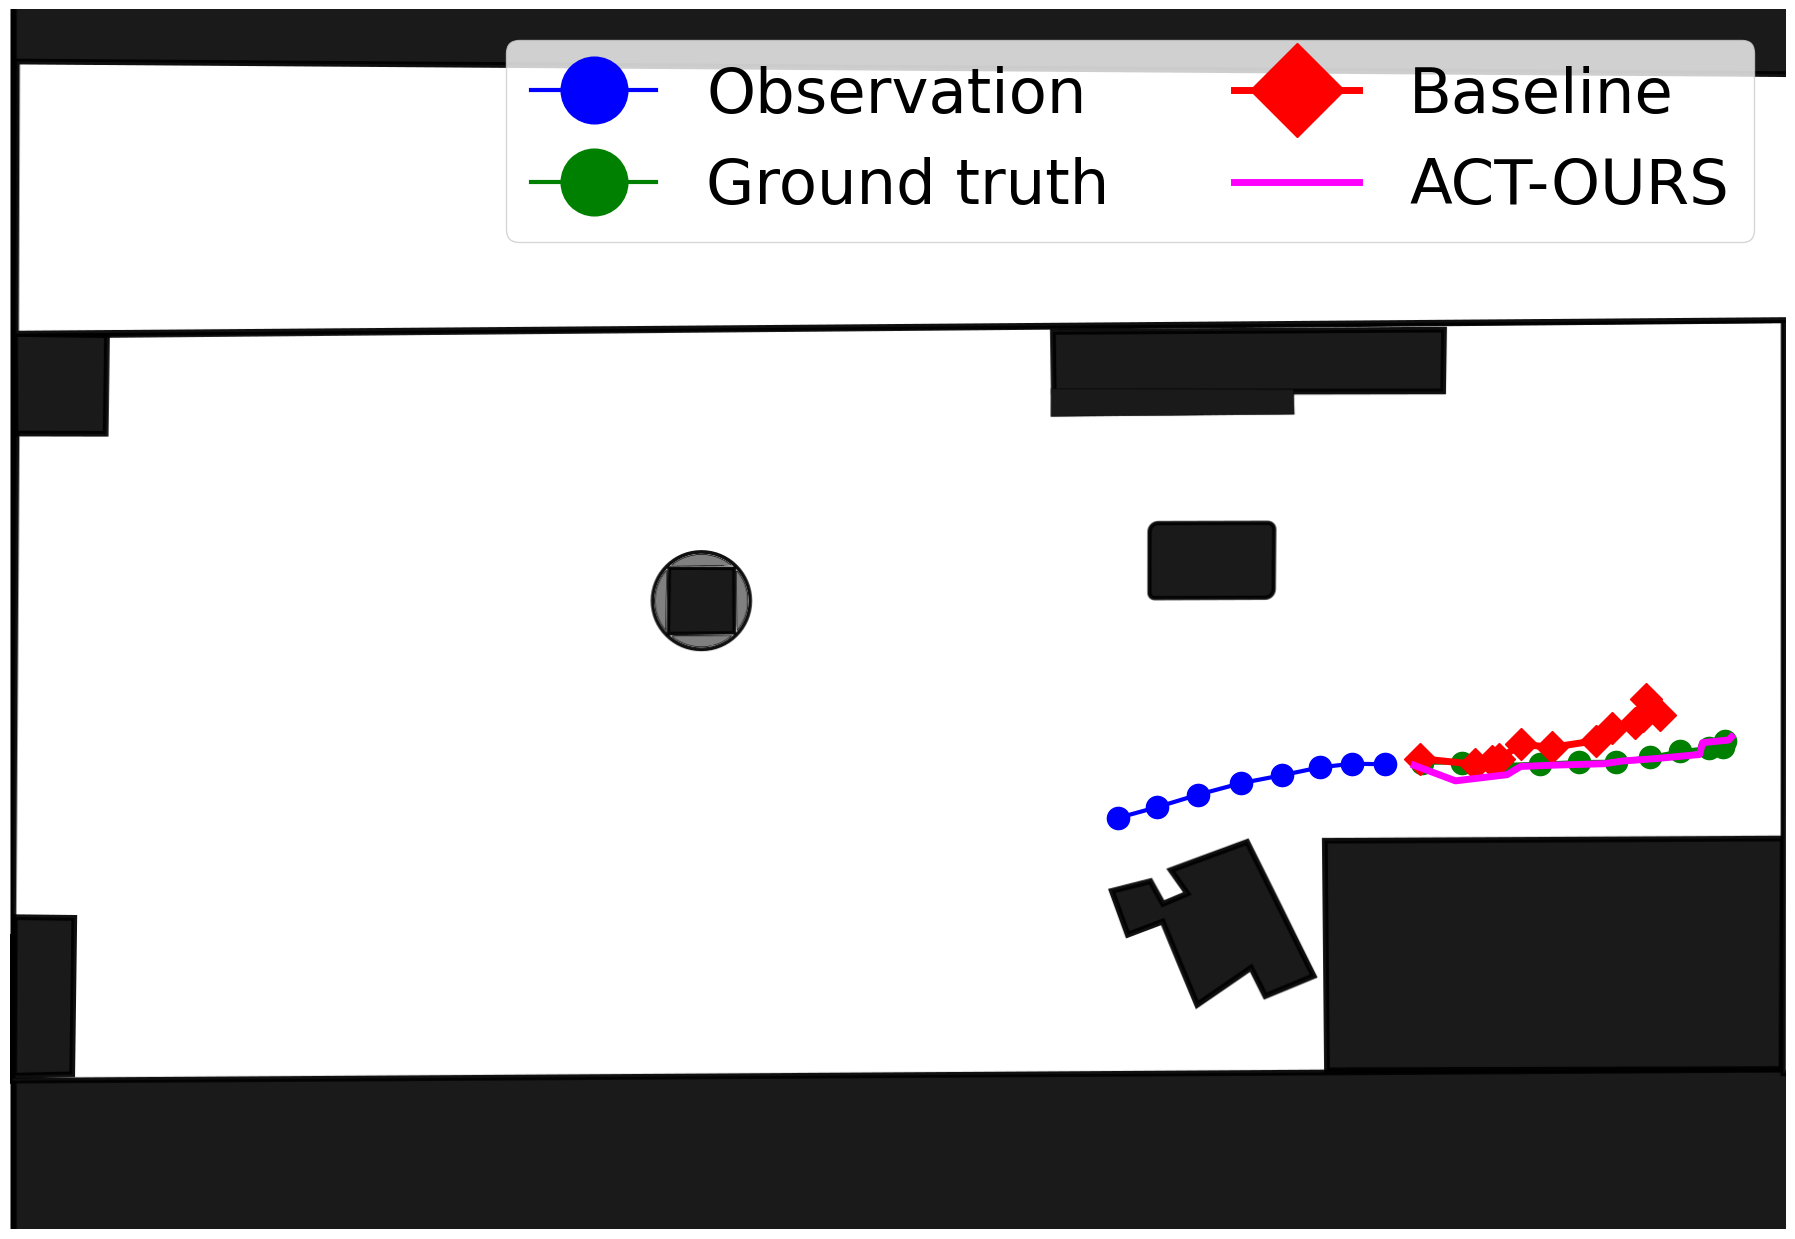

In [37]:
observations_plt = obs_batch[SAMPLE_IDX]
mtl_pred_plt = mtl_pred[0][SAMPLE_IDX]

if VISUALS_PATH:
    scenario_id = dataset_batch[SAMPLE_IDX]
    scenario_name = next(
        (
            key
            for key, value in test_dl.dataset.mapping_datasets.items()
            if value == scenario_id
        ),
        None,
    )
    all_maps = os.listdir(VISUALS_PATH)
    target_maps = [_map for _map in all_maps if "SC" + scenario_name.split(".png")[0][-1] in _map]
    for tm in target_maps[:1]:
        img = np.array(Image.open(os.path.join(VISUALS_PATH, tm)))
        spatial_layout = np.flipud(img[:, :, :3])
        plt.figure(figsize=(25, 12.5))
        plt.imshow(spatial_layout)
        month = "September" if tm.startswith("3009") else "May"

        obs_pix = pix2word_converters[month].convert2pixels(observations_plt)
        gt_pix = pix2word_converters[month].convert2pixels(ground_truth_plt)
        base_pix = pix2word_converters[month].convert2pixels(base_pred_plt)
        cond_pix = pix2word_converters[month].convert2pixels(cond_pred_plt)
        mtl_pix = pix2word_converters[month].convert2pixels(mtl_pred_plt)

        plot_predictions(obs_pix, gt_pix, base_pix, cond_pix)

        plt.xlim([0, 1790])
        plt.ylim([500, 1730])
        legend = plt.legend(prop={"size": 45}, markerscale=3, ncols=2)
        # plt.savefig("/home/tmr/Downloads/base_act_ours.svg")
else:
    plt.figure(figsize=(25, 12.5))
    plot_predictions(
        observations_plt, ground_truth_plt, base_pred_plt, cond_pred_plt
    )